## Семинар 2 "Распознавание рукописных цифр"

Ильин Илья Юрьевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys


from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
len(train_dataset)

60000

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

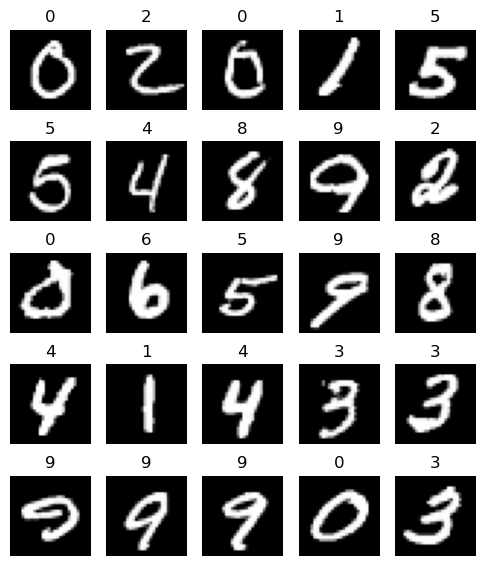

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [4]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.317/0.311	Accuracy: 0.917/0.918

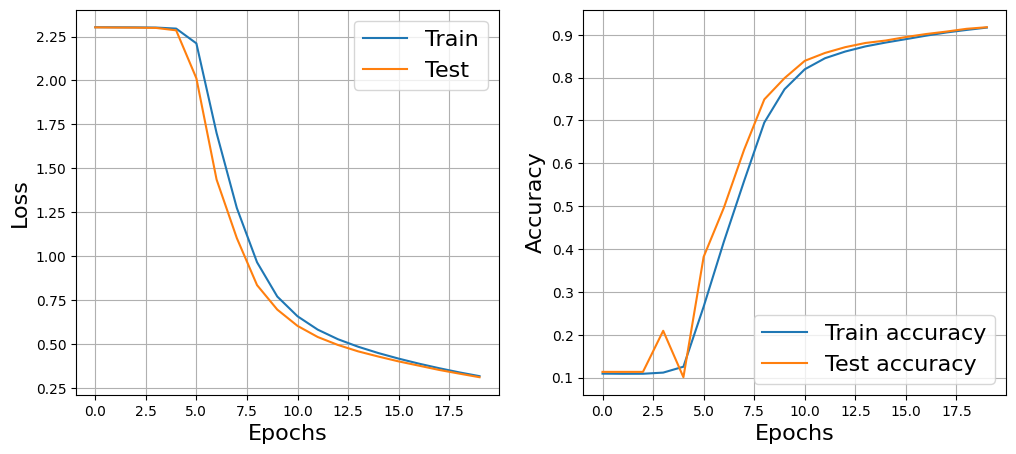

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [5]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [57]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [6]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 3... (Train/Test) NLL: 0.234/0.199	Accuracy: 0.933/0.941

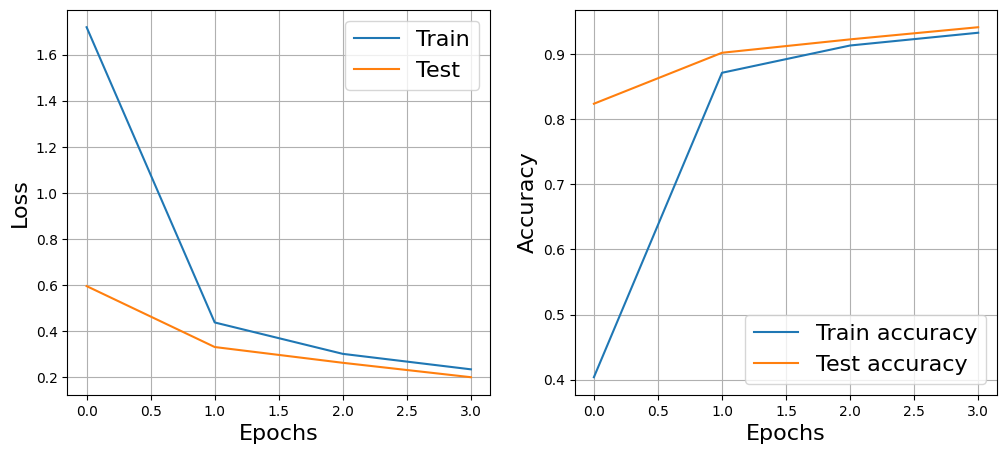

In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.077	Accuracy: 0.987/0.976

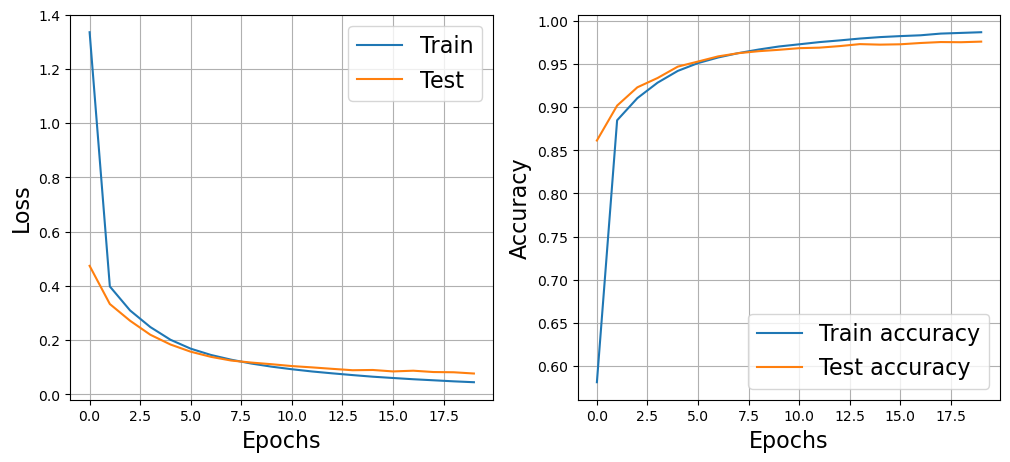

In [10]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

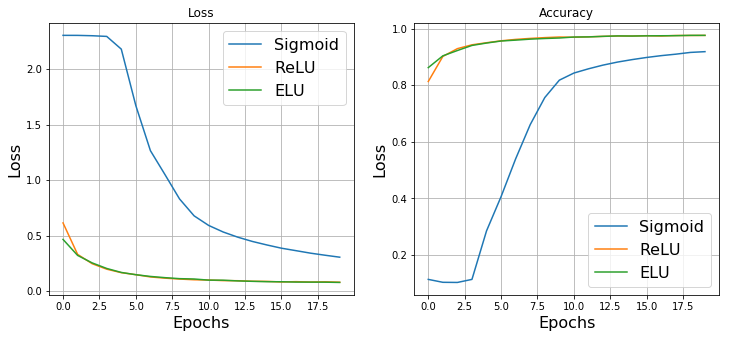

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [7]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        self.input = X
        return np.tanh(X)

    def backward(self, dLdy):
        tanh_x = np.tanh(self.input)
        return dLdy * (1 - tanh_x ** 2)

    def step(self, learning_rate):
        pass


Epoch 19... (Train/Test) NLL: 0.030/0.079	Accuracy: 0.994/0.976

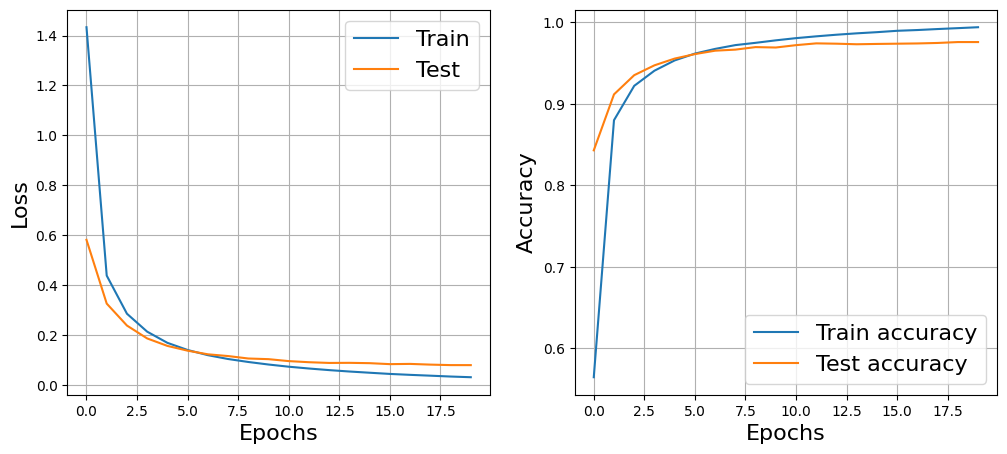

In [13]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

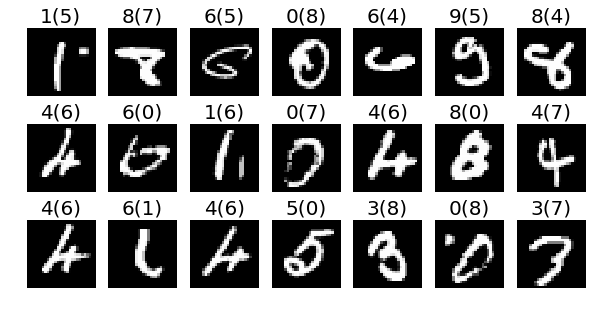

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

## Вообще есть два подхода:
1) Преобразования последовательно, т.е. сначала обучим сеть на исходном датасете, а потом дообучим на аугментированном
2) Объединить в один датасет исходные данные и аугментированные данные и потом обучить на одном датасете нейросеть
#### Более подходящий подход здесь 2), так как иначе есть риск слишком сильно подстроиться под аугментированные данные за счет чего ухудшится тестовый скор. 

### Ниже представлены реализации аугме

In [8]:
from skimage.transform import rotate
from skimage.transform import warp

class RandomRotate:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        img = np.array(img)
        rand_angle = np.random.uniform(-self.angle, self.angle)
        img = rotate(img, rand_angle, preserve_range=True)
        return img
       
        
class Shift:
    def __init__(self, shift_range):
        self.shift_range = shift_range

    def __call__(self, img):
        img = np.array(img)
        img = img.reshape((img.shape[0], img.shape[1], 1))
        shift_x = np.random.uniform(-self.shift_range, self.shift_range)
        shift_y = np.random.uniform(-self.shift_range, self.shift_range)
        img = warp(img, np.array([[1, 0, shift_x], 
                                  [0, 1, shift_y],
                                  [0, 0, 1]]))
        return img
        
class Noise:
    def __init__(self, noise_level):
        self.noise_level = noise_level

    def __call__(self, img):
        img = np.array(img, dtype=np.float64) 
        noise = np.random.normal(0, self.noise_level, img.shape)
        img += noise
        return img


In [12]:
base_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                    ])

rotation_transform = transforms.Compose([
                       RandomRotate(angle=10),  
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                    ])

shift_transform = transforms.Compose([
                       Shift(shift_range=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                    ])

noise_transform = transforms.Compose([
                       Noise(noise_level=10),  
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                    ])

res_transform = transforms.Compose([
                       RandomRotate(angle=10),
                       Shift(shift_range=3),
                       Noise(noise_level=30),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) 
                    ])

## Небольшие вращения

Epoch 19... (Train/Test) NLL: 0.307/0.238	Accuracy: 0.905/0.925

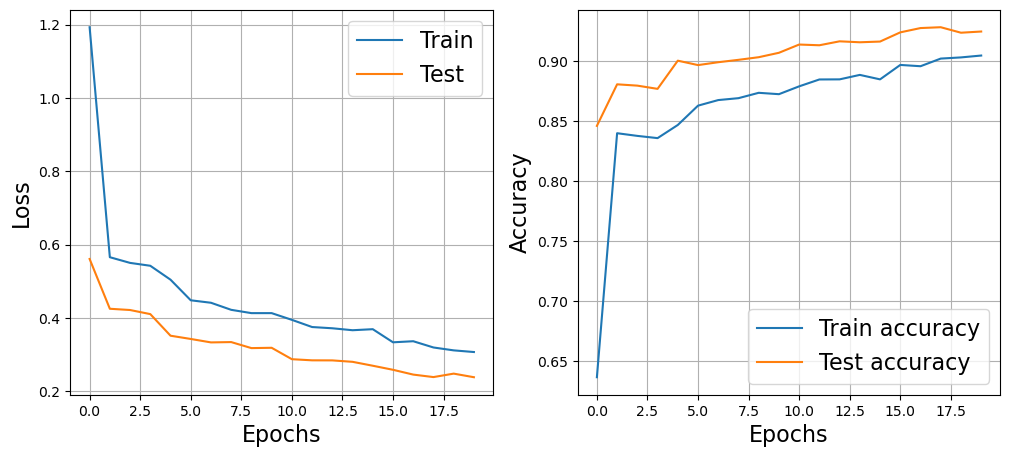

In [11]:
# предобработаем изначальные данные ( превратим в тензор и отнормируем)
train_dataset1 = MNIST('.', train=True, download=True, transform=base_transform)
train_dataset2 = MNIST('.', train=True, download=True, transform=rotation_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
test_dataset = MNIST('.', train=False, transform = base_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)




## Случайные сдвиги

Epoch 19... (Train/Test) NLL: 0.085/0.061	Accuracy: 0.975/0.981

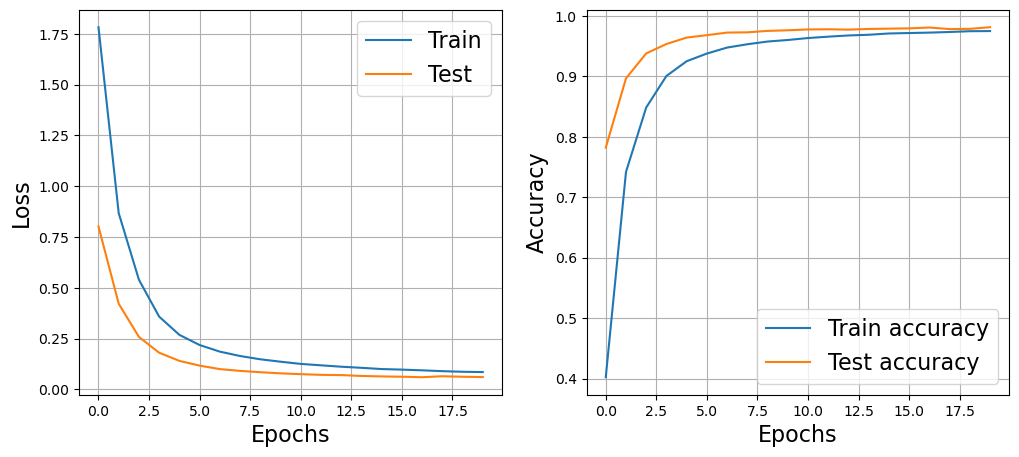

In [18]:
# предобработаем изначальные данные ( превратим в тензор и отнормируем)
train_dataset1 = MNIST('.', train=True, download=True, transform=base_transform)
train_dataset2 = MNIST('.', train=True, download=True, transform=shift_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
test_dataset = MNIST('.', train=False, transform = base_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)




## Шум

Epoch 19... (Train/Test) NLL: 0.300/0.246	Accuracy: 0.910/0.926

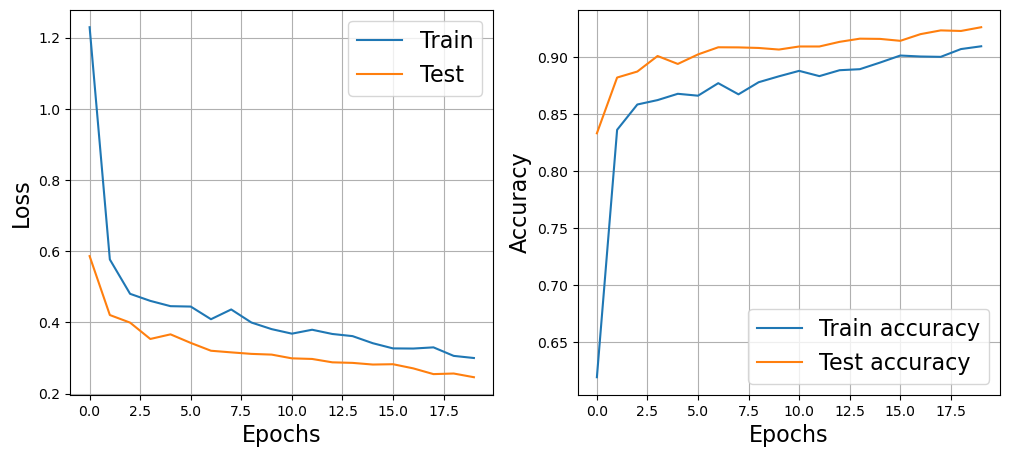

In [13]:
# предобработаем изначальные данные ( превратим в тензор и отнормируем)
train_dataset1 = MNIST('.', train=True, download=True, transform=base_transform)
train_dataset2 = MNIST('.', train=True, download=True, transform=noise_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])
test_dataset = MNIST('.', train=False, transform = base_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)




## Применение всех 3-ёх аугментаций

Epoch 19... (Train/Test) NLL: 0.074/0.096	Accuracy: 0.981/0.970

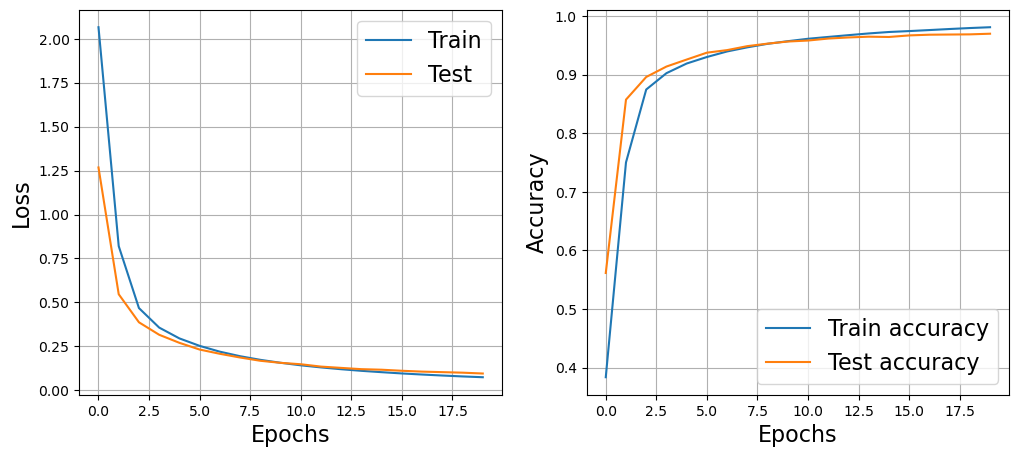

In [14]:
# предобрработаем изначальные данные ( превратим в тензор и отнормируем)
train_dataset = MNIST('.', train=True, download=True, transform=base_transform)
test_dataset = MNIST('.', train=False, transform = base_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)


### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?